Epoch 1, Validation Accuracy: 0.8095360164060498, Validation Loss: 0.4239692534169843
Epoch 2, Validation Accuracy: 0.8110740835683158, Validation Loss: 0.4146476561023343
Epoch 3, Validation Accuracy: 0.8159446295821584, Validation Loss: 0.4628369202536921
Epoch 4, Validation Accuracy: 0.8162009741092028, Validation Loss: 0.5075857889267706
Epoch 5, Validation Accuracy: 0.8190207639066905, Validation Loss: 0.5610851991561151
Epoch 6, Validation Accuracy: 0.8162009741092028, Validation Loss: 0.6025680101686909
Epoch 7, Validation Accuracy: 0.820815175596001, Validation Loss: 0.6676121604058051
Epoch 8, Validation Accuracy: 0.8167136631632914, Validation Loss: 0.7527805259150844
Epoch 9, Validation Accuracy: 0.8151755960010254, Validation Loss: 0.8363536432866128
Epoch 10, Validation Accuracy: 0.8115867726224045, Validation Loss: 0.9163633633044458
Epoch 11, Validation Accuracy: 0.8185080748526019, Validation Loss: 0.9557522679528883
Epoch 12, Validation Accuracy: 0.8118431171494489, Va

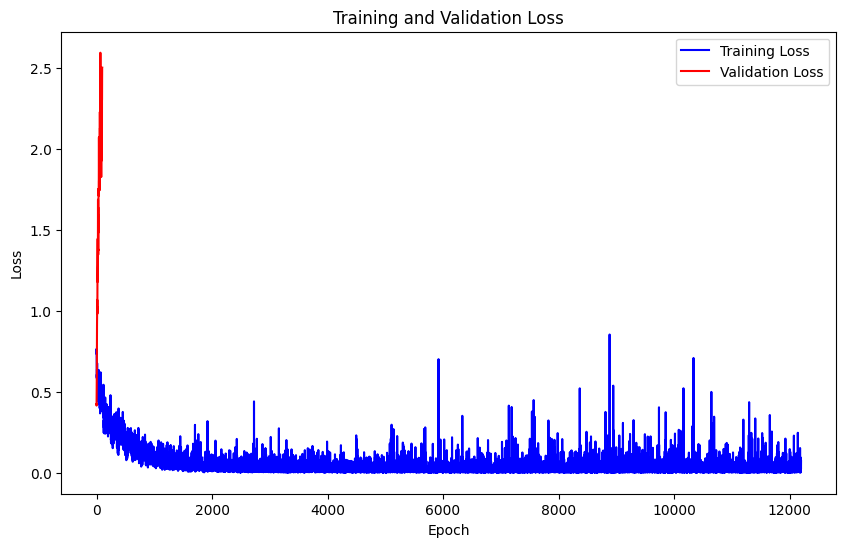

Final Training Loss: 0.07168064266443253
Final Validation Loss: 2.5014856861483667
Loss Difference (Validation - Training): 2.4298050434839342
Potential Overfitting Detected.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def create_pytorch_dnn(input_size,
                       n_layers,
                       n_units_l0,
                       dropout_l0,
                       n_units_l1,
                       dropout_l1,
                       optimizer_name,
                       lr,
                       num_classes):
    """
    Creates a PyTorch DNN model with the specified hyperparameters.

    Args:
        input_size (int): The size of the input features.
        n_layers (int): The number of layers in the network.
        n_units_l0 (int): Number of units in the first layer.
        dropout_l0 (float): Dropout rate for the first layer.
        n_units_l1 (int): Number of units in the second layer.
        dropout_l1 (float): Dropout rate for the second layer.
        optimizer_name (str): The name of the optimizer (e.g., "Adam", "RMSprop").
        lr (float): The learning rate.
        num_classes (int): The number of output classes.

    Returns:
        tuple: A tuple containing the model and the optimizer.  Returns None if optimizer_name is invalid
    """
    if n_layers != 2:
        raise ValueError("This function is designed for a 2-layer network.  n_layers should be 2.")

    model = nn.Sequential(
        nn.Linear(input_size, n_units_l0),
        nn.ReLU(),
        nn.Dropout(dropout_l0),
        nn.Linear(n_units_l0, n_units_l1),
        nn.ReLU(),
        nn.Dropout(dropout_l1),
        nn.Linear(n_units_l1, num_classes),
        nn.LogSoftmax(dim=1)
    )

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        print(f"Optimizer '{optimizer_name}' not supported.  Returning None.")
        return None, None

    return model, optimizer



if __name__ == '__main__':
    # Load your DataFrame (replace 'your_data.csv' with your actual file)
    df = pd.read_csv("dataset2_and_atomic_features.csv", index_col=0)

    # Assuming the last column is the target variable
    X = df.iloc[:, :-1].values.astype(np.float32)  # Features
    y = df.iloc[:, -1].values.astype(np.float32)  # Target

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train).long()
    X_val_tensor = torch.tensor(X_val)
    y_val_tensor = torch.tensor(y_val).long()

    # Create DataLoaders
    BATCH_SIZE = 128
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Hyperparameters
    input_size = X_train.shape[1]
    n_layers = 2
    n_units_l0 = 113
    dropout_l0 = 0.3316500162114466
    n_units_l1 = 104
    dropout_l1 = 0.3691858686507848
    optimizer_name = "RMSprop"
    lr = 0.0013291533636181113
    num_classes = 2

    # Create the model and optimizer
    model, optimizer = create_pytorch_dnn(input_size,
                                         n_layers,
                                         n_units_l0,
                                         dropout_l0,
                                         n_units_l1,
                                         dropout_l1,
                                         optimizer_name,
                                         lr,
                                         num_classes)
    if model is None or optimizer is None:
        exit()

    # Training loop with overfitting check
    EPOCHS = 100  # Or whatever number of epochs you want
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(DEVICE)

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                val_loss += F.nll_loss(output, target).item() # Accumulate validation loss
                pred = output.argmax(dim=1, keepdim=True)
                total += target.size(0)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(valid_loader) # Average validation loss
        val_losses.append(val_loss)
        accuracy = correct / total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy}, Validation Loss: {val_loss}")

    # Plotting and Overfitting Check
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Overfitting check:
    last_train_loss = train_losses[-1]
    last_val_loss = val_losses[-1]
    loss_difference = last_val_loss - last_train_loss

    print(f"Final Training Loss: {last_train_loss}")
    print(f"Final Validation Loss: {last_val_loss}")
    print(f"Loss Difference (Validation - Training): {loss_difference}")

    if loss_difference > 0.1 and last_val_loss > last_train_loss:
        print("Potential Overfitting Detected.")
    else:
        print("Model appears to be generalizing well.")
